In [1]:
using BenchmarkTools
using Random
using Statistics
using PythonCall
using DataFrames
using Printf
using LinearAlgebra
using CSV
using Distributions
using HiddenMarkovModels
using StateSpaceDynamics


In [2]:
const np = pyimport("numpy")
const dynamax = pyimport("dynamax.hidden_markov_model")
const jr = pyimport("jax.random")
const jnp = pyimport("jax.numpy")

Python: <module 'jax.numpy' from 'c:\\Users\\zachl\\OneDrive\\Documents\\GitHub\\StateSpaceDynamics.jl\\benchmarking\\.CondaPkg\\env\\Lib\\site-packages\\jax\\numpy\\__init__.py'>

In [ ]:
struct BenchConfig
    latent_dims::Vector{Int}
    input_dims::Vector{Int}
    obs_dims::Vector{Int} 
    seq_lengths::Vector{Int}
    n_iters::Int
    n_repeats::Int
end

default_config = BenchConfig(
    [2,4,8],       # latent dimensions
    [2,4,8],        # input dimension
    [1],      # observation dimensions 
    [100, 500, 1000],    # sequence lengths
    100,                 # EM iterations
    5                    # benchmark repeats
)

function initialize_transition_matrix(K::Int)
    # Initialize a transition matrix with zeros
    A = zeros(Float64, K, K)
    
    for i in 1:K
        # Sample from a Dirichlet distribution
        A[i, :] = rand(Dirichlet(ones(K)))
    end

    A .+= 0.5.*I(K)
    A .= A ./ sum(A, dims=2)
    return A
end

function initialize_state_distribution(K::Int)
    # initialize a state distribution
    return rand(Dirichlet(ones(K)))
end


function generate_random_hmm(latent_dim::Int, input_dim::Int, obs_dim::Int)
    """
    Create the StateSpaceDynamics.jl Model
    """
    # Create Gaussian Emission Models with random means and covariances
    emissions = Vector{BernoulliRegressionEmission}(undef, latent_dim)
    true_model = StateSpaceDynamics.SwitchingBernoulliRegression(K=latent_dim, input_dim=input_dim, output_dim=obs_dim, include_intercept=false)

    # Make the dynamax emission weights
    key=jr.PRNGKey(1)
    emission_dyna = jr.uniform(key, shape=(latent_dim, input_dim))
    emission_biases=jnp.zeros(input_dim)
    emission_ssd = pyconvert(Matrix, emission_dyna)
    emission_ssd = convert(Matrix{Float64}, emission_ssd)

    # Loop through each row of the emission_ssd matrix
    for (state, row) in enumerate(eachrow(emission_ssd))
        β = Matrix(reshape(row, :, 1))
        true_model.B[state] = BernoulliRegressionEmission(input_dim=input_dim, output_dim=obs_dim, β=β, include_intercept=false)
    end

    true_model.A = initialize_transition_matrix(latent_dim)
    true_model.πₖ = initialize_state_distribution(latent_dim)

    """
    Create the Dynamax Model
    """
    # Convert Julia parameters to NumPy arrays
    initial_probs = jnp.array(true_model.πₖ)  # Convert initial state probabilities
    transition_matrix = jnp.array(true_model.A)  # Convert transition matrix

    dynamax_model = dynamax.LogisticRegressionHMM(
    num_states=latent_dim,
    input_dim=input_dim
    )

    params, props = dynamax_model.initialize(
        method="prior",
        initial_probs=initial_probs,
        transition_matrix=transition_matrix,
        emission_weights=emission_dyna,
        emission_biases=emission_biases
    )

    return true_model, dynamax_model, params, props
end



function generate_test_data(model, seq_len::Int)
    # Generate random input data
    Φ = randn(model.B[1].input_dim, seq_len)

    # Sample from the model
    labels, data = StateSpaceDynamics.sample(model, Φ, n=seq_len)

    return model, labels, Φ, data
end


function run_single_benchmark(model_type::Symbol, hmm_ssd, y, inputs, params=nothing, props=nothing; config=default_config)
    if model_type == :julia
        bench = @benchmark begin
            model = deepcopy($hmm_ssd)  # Create a fresh copy for each iteration
            StateSpaceDynamics.fit!(model, $y, $inputs, max_iters=100, tol=1e-15)
        end samples=config.n_repeats
        return (time=median(bench).time, memory=bench.memory, allocs=bench.allocs, success=true)
    else
        bench = @benchmark begin
            dynamax_model=deepcopy($hmm_ssd)
            p = deepcopy($params)
            pr = deepcopy($props)
            dynamax_model.fit_em(p, pr, $y, $inputs, num_iters=100,verbose=false)
        end samples=config.n_repeats
        return (time=median(bench).time, memory=bench.memory, allocs=bench.allocs, success=true)        
    end
end

function benchmark_fitting(config::BenchConfig = default_config)
    results = []

    for latent_dim in config.latent_dims
        for input_dim in config.input_dims
            for obs_dim in config.obs_dims
                for seq_len in config.seq_lengths
                    println("\nTesting configuration: latent_dim=$latent_dim, input_dim=$input_dim, obs_dim=$obs_dim, seq_len=$seq_len")

                    # Create true model
                    true_model, dynamax_model, params, props = generate_random_hmm(latent_dim, input_dim, obs_dim)
                    
                    # Generate test data
                    model, labels, Φ, data = generate_test_data(true_model, seq_len)
                    vectorized_data = [data[:, i] for i in 1:size(data, 2)]  # Vectorize for HMMjl

                    # Convert inputs to NumPy format (inputs are seq_len x input_dim in dynamax)
                    inputs_np = np.array(Φ')
                    data_np = np.array(data)[0]
                    labels_np = np.array(labels .- 1)  # Dynamax expects labels indexed from 0

                    # Generate random HMMs for fitting
                    test_model, dynamax_model, params, props = generate_random_hmm(latent_dim, input_dim, obs_dim)

                    # Run benchmarks separately with error handling
                    julia_result = try
                        run_single_benchmark(:julia, test_model, data, Φ)
                    catch err
                        println("Error in SSD.jl benchmarking: ", err)
                        (time="FAIL", memory="FAIL", allocs="FAIL", success=false)
                    end

                    dynamax_result = try
                        run_single_benchmark(:dynamax, dynamax_model, data_np, inputs_np, params, props)
                    catch err
                        println("Error in dynamax benchmarking: ", err)
                        (time="FAIL", memory="FAIL", allocs="FAIL", success=false)
                    end

                    # Save results
                    push!(results, Dict(
                        "config" => (latent_dim=latent_dim, input_dim=input_dim, obs_dim=obs_dim, seq_len=seq_len),
                        "SSD.jl" => julia_result,
                        "Dynamax" => dynamax_result
                    ))
                end
            end
        end
    end

    return results
end

benchmark_fitting (generic function with 2 methods)

In [4]:
results = benchmark_fitting()


Testing configuration: latent_dim=2, input_dim=2, obs_dim=1, seq_len=100


Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:06 (12.42 ms/it)
Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:02 ( 4.04 ms/it)
Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:01 ( 3.60 ms/it)
Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:01 ( 3.70 ms/it)
Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:01 ( 3.96 ms/it)
Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:01 ( 3.22 ms/it)
Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:01 ( 3.26 ms/it)



Testing configuration: latent_dim=2, input_dim=2, obs_dim=1, seq_len=500


Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:13 (27.88 ms/it)
Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:14 (28.51 ms/it)
Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:14 (28.08 ms/it)



Testing configuration: latent_dim=2, input_dim=2, obs_dim=1, seq_len=1000


Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:29 (58.53 ms/it)
Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:31 (63.32 ms/it)
Running EM algorithm... 100%|██████████████████████████████████████████████████| Time: 0:00:30 (61.86 ms/it)


3-element Vector{Any}:
 Dict{String, NamedTuple}("Dynamax" => (time = 6.447488e8, memory = 1424, allocs = 25, success = true), "config" => (latent_dim = 2, input_dim = 2, obs_dim = 1, seq_len = 100), "SSD.jl" => (time = 1.6288082e9, memory = 883256400, allocs = 8255953, success = true))
 Dict{String, NamedTuple}("Dynamax" => (time = 1.7907594e9, memory = 1424, allocs = 25, success = true), "config" => (latent_dim = 2, input_dim = 2, obs_dim = 1, seq_len = 500), "SSD.jl" => (time = 1.40737889e10, memory = 6684200928, allocs = 64989108, success = true))
 Dict{String, NamedTuple}("Dynamax" => (time = 3.50100195e9, memory = 1424, allocs = 25, success = true), "config" => (latent_dim = 2, input_dim = 2, obs_dim = 1, seq_len = 1000), "SSD.jl" => (time = 3.09970103e10, memory = 13290087072, allocs = 129471175, success = true))

In [5]:
using CSV
using DataFrames

function prepare_results_for_csv(results)
    rows = []
    for result in results
        config = result["config"]
        ssd = result["SSD.jl"]
        Dynamax = result["Dynamax"]

        # Add a row for SSD.jl
        push!(rows, (
            latent_dim=config.latent_dim,
            obs_dim=config.obs_dim,
            seq_len=config.seq_len,
            library="SSD.jl",
            time=ssd.time,
            memory=ssd.memory,
            allocs=ssd.allocs,
            success=ssd.success,
        ))

        # Add a row for HMM.jl
        push!(rows, (
            latent_dim=config.latent_dim,
            obs_dim=config.obs_dim,
            seq_len=config.seq_len,
            library="Dynamax",
            time=Dynamax.time,
            memory=Dynamax.memory,
            allocs=Dynamax.allocs,
            success=Dynamax.success,
        ))
    end
    return DataFrame(rows)
end

results_df = prepare_results_for_csv(results)
CSV.write("benchmark_results.csv", results_df)


"benchmark_results.csv"

In [6]:
function transform_to_df(data_vector::Vector)
    # Initialize vectors for all our columns
    packages = String[]
    times = Float64[]
    memories = Int[]
    allocs = Int[]
    successes = Bool[]
    latent_dims = Int[]
    obs_dims = Int[]
    seq_lens = Int[]
    
    # Process each dictionary in the vector
    for dict in data_vector
        # Get configuration values for this batch
        config = dict["config"]
        latent_dim = config.latent_dim
        obs_dim = config.obs_dim
        seq_len = config.seq_len
        
        # Process each package's results
        for (pkg_name, results) in dict
            if pkg_name != "config"
                push!(packages, pkg_name)
                push!(times, results.time)
                push!(memories, results.memory)
                push!(allocs, results.allocs)
                push!(successes, results.success)
                push!(latent_dims, latent_dim)
                push!(obs_dims, obs_dim)
                push!(seq_lens, seq_len)
            end
        end
    end
    
    # Create the DataFrame
    DataFrame(
        package = packages,
        time = times,
        memory = memories,
        allocs = allocs,
        success = successes,
        latent_dim = latent_dims,
        obs_dim = obs_dims,
        seq_length = seq_lens
    )
end

function plot_benchmarks(df::DataFrame)
    # Create a unique identifier for each obs_dim/latent_dim combination
    df.dim_combo = string.(df.obs_dim, "x", df.latent_dim)
    
    # Define line styles that will cycle if we have more combinations than styles
    base_styles = [:solid, :dash, :dot, :dashdot, :dashdotdot]
    dim_combos = unique(df.dim_combo)
    
    # Create style dictionary by cycling through available styles
    style_dict = Dict(
        combo => base_styles[mod1(i, length(base_styles))] 
        for (i, combo) in enumerate(dim_combos)
    )
    
    # Create the plot
    p = plot(
        xlabel="Sequence Length",
        ylabel="Time (seconds)",
        title="Package Performance Across Sequence Lengths",
        legend=:outertopright,
        xscale=:log10,
        yscale=:log10
    )
    
    # Plot each package with a different color
    packages = unique(df.package)
    for (i, pkg) in enumerate(packages)
        pkg_data = df[df.package .== pkg, :]
        
        # Plot each dimension combination for this package
        for dim_combo in dim_combos
            combo_data = pkg_data[pkg_data.dim_combo .== dim_combo, :]
            if !isempty(combo_data)
                plot!(
                    p,
                    combo_data.seq_length,
                    combo_data.time ./ 1e9,  # Convert to seconds
                    label="$(pkg) ($(dim_combo))",
                    color=i,
                    linestyle=style_dict[dim_combo],
                    marker=:circle,
                    markersize=4
                )
            end
        end
    end
    
    # Add gridlines and adjust layout
    plot!(
        p,
        grid=true,
        minorgrid=true,
        size=(900, 600),
        margin=10Plots.mm
    )
    
    return p
end

plot_benchmarks (generic function with 1 method)

In [7]:
df = transform_to_df(results)
df.time = df.time / 1e9;

CSV.write("benchmark_results_bernoulli.csv", df)


"benchmark_results_bernoulli.csv"

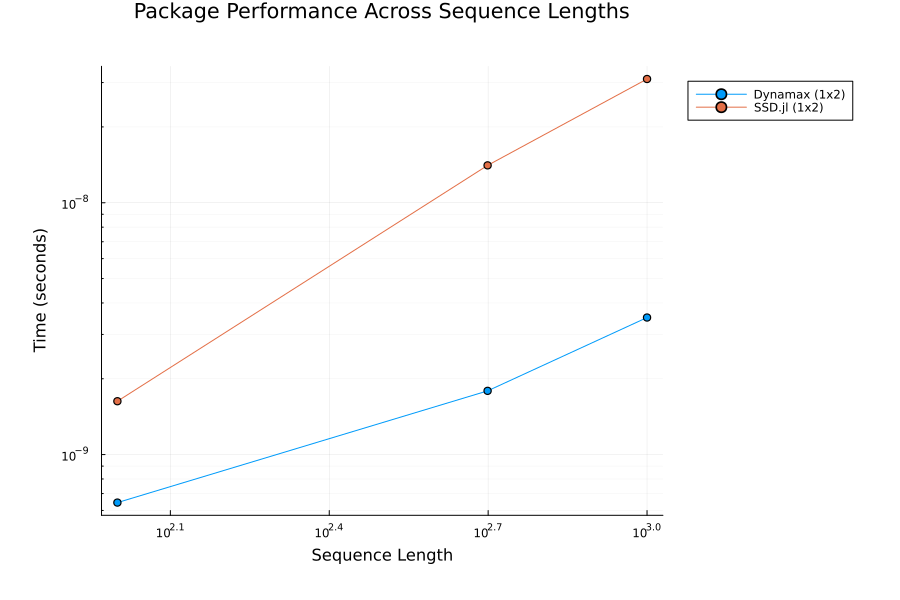

In [8]:
using Plots
benchmark_plot = plot_benchmarks(df)